Sulla base di https://github.com/langchain-ai/research-rabbit

In [23]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["TAVILY_API_KEY"]

'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'

In [24]:
import os
from dataclasses import dataclass, field, fields
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated
from dataclasses import dataclass

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = 3
    local_llm: str = "llama3.2"

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [25]:
query_writer_instructions="""Your goal is to generate targeted web search query.

The query will gather information related to a specific topic.

Topic:
{research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""

summarizer_instructions="""Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered
2. Maintain consistency with the existing content's style and depth
3. Only add new, non-redundant information
4. Ensure smooth transitions between existing and new content

When creating a NEW summary:
1. Highlight the most relevant information from each source
2. Provide a concise overview of the key points related to the report topic
3. Emphasize significant findings or insights
4. Ensure a coherent flow of information

In both cases:
- Focus on factual, objective information
- Maintain a consistent technical depth
- Avoid redundancy and repetition
- DO NOT use phrases like "based on the new results" or "according to additional sources"
- DO NOT add a preamble like "Here is an extended summary ..." Just directly output the summary.
- DO NOT add a References or Works Cited section.
"""

reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{ 
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}"""

translator_instructions="""Your goal is to translate the summary given into italian language.
Do not translate links in sources section.
"""

In [26]:
import operator
from dataclasses import dataclass, field
from typing_extensions import TypedDict, Annotated

@dataclass(kw_only=True)
class SummaryState:
    research_topic: str = field(default=None) # Report topic     
    search_query: str = field(default=None) # Search query
    web_research_results: Annotated[list, operator.add] = field(default_factory=list) 
    sources_gathered: Annotated[list, operator.add] = field(default_factory=list) 
    research_loop_count: int = field(default=0) # Research loop count
    running_summary: str = field(default=None) # Final report
    italian_summary: str = field(default=None) # Final report

@dataclass(kw_only=True)
class SummaryStateInput(TypedDict):
    research_topic: str = field(default=None) # Report topic     

@dataclass(kw_only=True)
class SummaryStateOutput(TypedDict):
    italian_summary: str = field(default=None) # Final report

In [27]:
from tavily import TavilyClient

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources.
    
    Args:
        search_results (dict): Tavily search response containing results
        
    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )


def tavily_search(query, include_raw_content=True, max_results=3):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        include_raw_content (bool): Whether to include the raw_content from Tavily in the formatted string
        max_results (int): Maximum number of results to return
        
    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
#    tavily_client = TavilyClient()
    tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=include_raw_content)

In [28]:
import json

from typing_extensions import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph

# LLM
llm = ChatOllama(model=Configuration.local_llm, temperature=0)
llm_json_mode = ChatOllama(model=Configuration.local_llm, temperature=0, format="json")

# Nodes   
def generate_query(state: SummaryState):
    """ Generate a query for web search """
    
    print("genero la query")
    # Format the prompt
    query_writer_instructions_formatted = query_writer_instructions.format(research_topic=state.research_topic)

    # Generate a query
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
        HumanMessage(content=f"Generate a query for web search:")]
    )   
    query = json.loads(result.content)
    print(f"Query generata : {query}")

    
    return {"search_query": query['query']}

def web_research(state: SummaryState):
    """ Gather information from the web """

    print("Effettuo la ricerca")
    # Search the web
    search_results = tavily_search(state.search_query, include_raw_content=True, max_results=1)
    
    # Format the sources
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    print(f"Esito ricerca : {search_str}")
    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

def summarize_sources(state: SummaryState):
    """ Summarize the gathered sources """

    print("Effettuo sommario")
    # Existing summary
    existing_summary = state.running_summary

    # Most recent web research
    most_recent_web_research = state.web_research_results[-1]

    # Build the human message
    if existing_summary:
        human_message_content = (
            f"Extend the existing summary: {existing_summary}\n\n"
            f"Include new search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )
    else:
        human_message_content = (
            f"Generate a summary of these search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )

    # Run the LLM
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    running_summary = result.content
    print(f"Sommario : {running_summary}")
    return {"running_summary": running_summary}

def reflect_on_summary(state: SummaryState):
    """ Reflect on the summary and generate a follow-up query """

    print("Ragiono sul sommario")
    # Generate a query
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.running_summary}")]
    )   
    follow_up_query = json.loads(result.content)

    # Overwrite the search query
    return {"search_query": follow_up_query['follow_up_query']}

def finalize_summary(state: SummaryState):
    """ Finalize the summary """

    print("Finalizzo il sommario")
    # Format all accumulated sources into a single bulleted list
    all_sources = "\n".join(source for source in state.sources_gathered)
    state.running_summary = f"## Summary\n\n{state.running_summary}\n\n ### Sources:\n{all_sources}"
    return {"running_summary": state.running_summary}

def translate_summary(state: SummaryState):
    """ Summarize the gathered sources """

    print("Effettuo TRaduzione")
    # Existing summary
    existing_summary = state.running_summary

    # Build the human message
    human_message_content = (
        f"Translate in italian the existing summary: {existing_summary}\n\n"
    )

    # Run the LLM
    result = llm.invoke(
        [SystemMessage(content=translator_instructions),
        HumanMessage(content=human_message_content)]
    )

    italian_summary = result.content
    print(f"Sommario in italiano : {italian_summary}")
    return {"italian_summary": italian_summary}


def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """ Route the research based on the follow-up query """

    print("Route Research")
    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        return "web_research"
    else:
        return "finalize_summary" 
    
# Add nodes and edges 
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput, config_schema=Configuration)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)
builder.add_node("translate_summary", translate_summary)

# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", "translate_summary")
builder.add_edge("translate_summary", END)

graph = builder.compile()

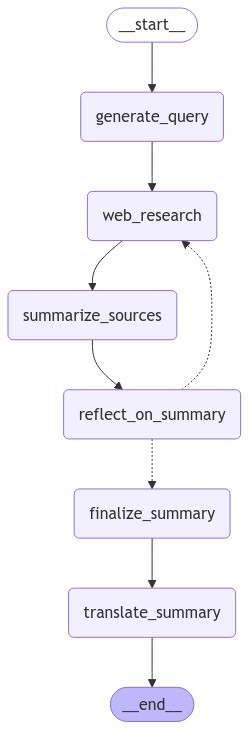

In [29]:
from langgraph.graph import StateGraph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:
report_topic ="what are the best framework to build llm agents?"
report=graph.invoke({"research_topic":report_topic,
                           "Configuration": Configuration.from_runnable_config()})
report

genero la query
Query generata : {'query': 'best frameworks for building large language model (LLM) agents', 'aspect': 'development frameworks', 'rationale': 'looking for recommendations on the most suitable frameworks for creating LLM agents'}
Effettuo la ricerca
Esito ricerca : Sources:

Source A Tour of Popular Open Source Frameworks for LLM-Powered Agents:
===
URL: https://blog.dataiku.com/open-source-frameworks-for-llm-powered-agents
===
Most relevant content from source: The purpose of this blog post is to present some of the most popular open source Python frameworks used to implement LLM-powered agents. CrewAI and AutoGen are presented as multi-agent frameworks while LlamaIndex focuses on single agent systems, and LangGraph enables both approaches. Distinctive Features of Agent Frameworks Please note that the LlamaIndex team is currently building llama-agents, a “powerful framework for building production multi-agent AI systems” but we do not cover it in this blog post because 

{'italian_summary': "Ecco la traduzione dell'articolo in italiano:\n\n## Riepilogo\n\nEcco una continuazione del riassunto precedente.\n\nAvvolgere un agente AutoGen in un nodo LangGraph\nLa sezione precedente ha fornito un' panoramica su come definire e avvolgere un agente AutoGen all'interno di un solo nodo LangGraph. Questo processo implica la creazione di una funzione `create_agent` che restituisce un'istanza dell'agente AutoGen con una configurazione specifica, e un'altra funzione `create_node` che avvolge questo agente all'interno di un nodo LangGraph.\n\nGestione degli errori di chiamata strumentale in LangGraph\nLa chiamata strumentale è un aspetto critico degli agenti ReAct implementati con LangGraph. Tuttavia, la chiamata strumentale può incontrare problemi a causa dell'errore strumentale da parte del LLM o di aspettative di input non allineate. Questa sezione copre strategie e esempi per gestire efficacemente gli errori di chiamata strumentale in LangGraph.\n\nGestione degli